# **Used Car Price Predictor Notebook**

### import required libraries

In [1]:
import keras 
import pandas as pd
import pandasql as sqldf
from zip_to_state import zip_to_state, state_to_abbrev
import plotly.express as px
import numpy as np
from scipy import stats
import seaborn as sns


## **Phase 1: Data Collection**
#### **Step 1: Extract Training Data from Parquet File**

In [ ]:
# time to run: 4m 57s
df = pd.read_csv('used_cars_data.csv')

# ---------------------------------------------------------------------------

#### **Step 2: Preview the Dataset's Schema**

In [38]:
pd.reset_option('all')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.head(2)
# df.shape
# df.columns


,make_name,model_name,trim_name,year,body_type,listing_color,mileage,horsepower,is_new,salvage,daysonmarket,state,price
0,Jeep,Wrangler Unlimited,Sahara 4WD,2007,SUV / Crossover,BLUE,153205.0,205.0,False,False,24,New Jersey,12999.0
1,Ford,Transit Connect,Cargo XL FWD,2011,Van,WHITE,176263.0,136.0,False,False,47,New Jersey,4999.0


# ---------------------------------------------------------------------------

## **MLOPs Phase 2: Data Ingestion**
#### For the purposes of this tutorial, we will not be ingesting data. However, in an organizational setting, you'll use an ingestion framework, such as Apache Airflow, Apache Spark, or Apache Kafka, to collect data into a Data Lake to create a curated Training Dataset.

## **MLOPs Phase 3: Data Storage **
#### Since we already extracted this data was previously extracted from BigQuery, this phase has already been completed. Typically, you'll use a Cloud Storage Bucket (e.g., AWS S3, Google Cloud Storage) to store all data to be used in ML applications.

# ---------------------------------------------------------------------------

## **MLOps Phase 5: Exploratory Data Analysis (EDA)**

#### **Find the total number of missing values per column**

In [26]:
for col in df.columns:
    # Count rows with NaN as 'mileage'
    nan_mileage_count = df[col].isna().sum()

    # Print the count
    print(f"{col}: {nan_mileage_count}")
    

make_name: 0
model_name: 0
trim_name: 112263
year: 0
body_type: 12828
listing_color: 0
mileage: 0
horsepower: 0
is_new: 0
salvage: 0
daysonmarket: 0
state: 0
price: 0


#### **Catagorical Data Col Analysis**

In [ ]:
categorical_columns = ['body_type', 'listing_color','has_accidents','is_new','salvage','wheel_system','make_name','trim_name' 'frame_damaged','fleet']
#'exterior_color'
unique_value_counts = df[categorical_columns].nunique()

value_frequencies = {}
for col in categorical_columns:
    value_frequencies[col] = df[col].value_counts()

print("Count of Unique Values:")
print(unique_value_counts)


In [ ]:
# Loop through categorical columns and create histograms
for col, frequencies in value_frequencies.items():
    fig = px.bar(frequencies, x=frequencies.index, y=frequencies.values, labels={'x': col, 'y': 'Frequency'})
    
    # Customize the layout if needed
    fig.update_layout(
        title=f'Histogram of {col}',
        xaxis_title=col,
        yaxis_title='Frequency',
        xaxis={'categoryorder':'total descending'}  # Sort categories by frequency
    )
    
    fig.show()  

#### **Numerical Data Col Analysis**

In [ ]:

numerical_columns = [ 
       'horsepower','daysonmarket', 'mileage', 'owner_count', 'price','year',] 

summary_statistics = df[numerical_columns].describe()
rounded_summary_statistics = summary_statistics.round(2)  
print(rounded_summary_statistics)


In [4]:
df = zip2State(df)

In [ ]:

x_range_price = [0, 200000]
x_range_year = [1995, 2022]
x_range_mileage = [0, 100000]

fig_price = px.histogram(df, x='price', title='Price Distribution - Outliers removed', range_x=x_range_price,  nbins=500)
fig_mileage = px.histogram(df, x='mileage', title='Mileage Distribution - Outliers removed', range_x=x_range_mileage,  nbins=32000)
fig_year = px.histogram(df, x='year', title='Year Distribution - Outliers removed', range_x=x_range_year)

state_summary = pd.DataFrame(df['dealer_zip'].astype(str).str[:5])
state_summary['state'] = state_summary['dealer_zip'].astype(int).apply(
    lambda zip_code: next((state for (zipcode_range, state) in zip_to_state.items() if zip_code >= zipcode_range[0] and zip_code <= zipcode_range[1]), 'Unknown')
)
state_summary = state_summary.groupby('state').size().reset_index(name='total_listings')
state_summary['state_abbr'] = state_summary['state'].map(state_to_abbrev)
state_summary = state_summary[state_summary['state_abbr'] != 'Unknown']
max_value = state_summary['total_listings'].max()
fig_map = px.choropleth(
    state_summary,
    locations='state_abbr',  
    locationmode='USA-states',      
    color='total_listings',       
    color_continuous_scale='greens',
    range_color=(0, max_value), 
    scope='usa'                  
)

fig_map.update_geos(fitbounds='locations', visible=False)
fig_map.show()

fig_price.show()
fig_mileage.show()
fig_year.show()


#### **Find total outliers per col and how many standard deviations out**

In [ ]:

# # Assuming df is your DataFrame with columns "mileage," "owner_count," "price," and "year"
columns_of_interest = [ 'mileage', 'year','horsepower','price']
# Initialize a dictionary to store outlier counts for each column
outlier_counts = {}

# Set the Z-score threshold for identifying outliers
z_score_threshold = 20 # You can adjust this threshold as needed

for col in columns_of_interest:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers = (z_scores > z_score_threshold)
    outlier_count = outliers.sum()
    outlier_counts[col] = outlier_count

#Display the counts of outliers for each column
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

# Identify outliers for the "price" column
price_z_scores = np.abs(stats.zscore(df['price']))
price_outliers = (price_z_scores > z_score_threshold)
# Filter the DataFrame to get rows where "price" is an outlier
price_outlier_rows = df[price_outliers]
desired_columns = ['make_name','model_name', 'year', 'mileage', 'price']
price_outlier_rows = price_outlier_rows[desired_columns]
# Print the rows that are outliers for the "price" column
print("Rows where 'price' is an outlier:")
print(price_outlier_rows.sort_values(by='price', ascending=False))

In [ ]:
def custom_format(x):
    if x >= 1e6:
        return '{:.4g} mil'.format(x / 1e6)
    elif x >= 1e3:
        return '{:.4g}k'.format(x / 1e3)
    else:
        return '{:.4g}'.format(x)

# # Apply the custom formatting function to specific columns using applymap
# columns_to_format = ['price', 'daysonmarket','horsepower','mileage','owner_count']  # Add the columns you want to format
# price_outlier_rows[columns_to_format] = price_outlier_rows[columns_to_format].applymap(custom_format)

# Assuming you want to generate summary statistics only for the "price" column
price_outlier_rows[['price']].sort_values(by='price', ascending=False).applymap(custom_format)



#### **Create Correlation Matrix**

               mileage     price      year  horsepower  daysonmarket
mileage       1.000000 -0.274146 -0.460669   -0.015064     -0.046596
price        -0.274146  1.000000  0.356537    0.604833      0.063200
year         -0.460669  0.356537  1.000000    0.027329     -0.001077
horsepower   -0.015064  0.604833  0.027329    1.000000     -0.019991
daysonmarket -0.046596  0.063200 -0.001077   -0.019991      1.000000


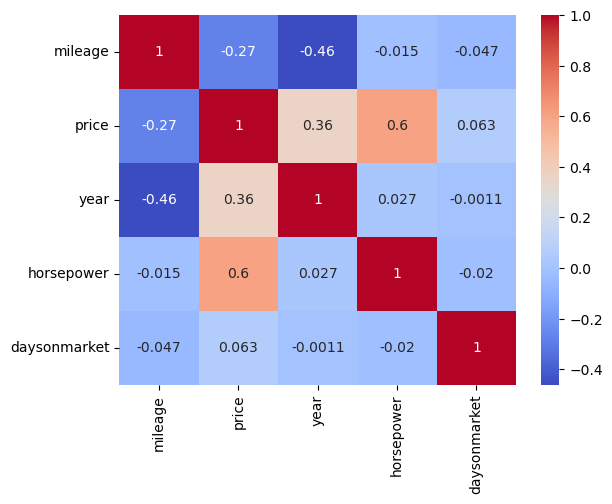

In [20]:
corr_matrix = df[['mileage', 'price', 'year', 'horsepower','daysonmarket']].corr()
print(corr_matrix)
plt = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


## **DataPipline (Preparation and Wrangling)**

# ---------------------------------------------------------------------------
#### **Step 1: Use Intuition to Remove Irrelevant Features**

In [13]:
columns_to_be_removed = ['power',"latitude","longitude","city","vin","back_legroom","bed","bed_height","bed_length","cabin","city_fuel_economy","combine_fuel_economy","engine_cylinders","engine_displacement","engine_type","franchise_dealer","franchise_make","front_legroom","fuel_tank_volume","fuel_type","height","highway_fuel_economy","interior_color","isCab","is_certified","is_cpo","is_oemcpo","length","listed_date","listing_id","main_picture_url","maximum_seating","savings_amount","seller_rating","sp_id","sp_name","theft_title","torque","transmission","transmission_display","vehicle_damage_category","wheel_system_display","wheelbase","width",'trimId', 'major_options']
# columns_to_be_removed = ["exterior_color"]
df = df.drop(columns=columns_to_be_removed)

KeyError: "['power', 'latitude', 'longitude', 'city', 'vin', 'back_legroom', 'bed', 'bed_height', 'bed_length', 'cabin', 'city_fuel_economy', 'combine_fuel_economy', 'engine_cylinders', 'engine_displacement', 'engine_type', 'franchise_dealer', 'franchise_make', 'front_legroom', 'fuel_tank_volume', 'fuel_type', 'height', 'highway_fuel_economy', 'interior_color', 'isCab', 'is_certified', 'is_cpo', 'is_oemcpo', 'length', 'listed_date', 'listing_id', 'main_picture_url', 'maximum_seating', 'savings_amount', 'seller_rating', 'sp_id', 'sp_name', 'theft_title', 'torque', 'transmission', 'transmission_display', 'vehicle_damage_category', 'wheel_system_display', 'wheelbase', 'width', 'trimId', 'major_options'] not found in axis"

#### **Remove price outliers for each row depending on like make , model and year vehicles**

In [9]:
import pandas as pd

def get_outliers(group):
    z_scores = stats.zscore(group['price'])
    threshold = 8
    outlier_indices = (z_scores > threshold) | (z_scores < -threshold)
    return group[outlier_indices]
outliers = df.groupby(['make_name', 'model_name', 'year'], group_keys=False).apply(get_outliers)
outliers.reset_index(drop=True, inplace=True)
df = df.drop(outliers.index)
df.reset_index(drop=True, inplace=True)


In [22]:
filtered_df.shape

(2999782, 19)

In [ ]:
outliers = df.groupby(['make_name', 'model_name', 'year'], group_keys=False).apply(get_outliers)


outliers.sort_values(by='price', ascending=False).head(100)
outliers

#### **Convert all data in each column to target type**

In [ ]:

data_types = {
    'fleet': bool,
    'frame_damaged': bool,
    'has_accidents': bool,
    'is_new': bool,
    'mileage': int,
    'owner_count': int,
    'price': int,
    'salvage': bool,
    'year': int,
}

# Use the astype method to convert columns to the specified data types
df = df.astype(data_types)

# If you want to convert 'listing_color', 'make_name', 'model_name',  'trim_name', and 'wheel_system' columns to string
string_columns = ['listing_color', 'make_name', 'model_name', 'trim_name', 'wheel_system']
df[string_columns] = df[string_columns].astype(str)


#### **Salvage Imputation, if "salvage found in desc. then true else false**

In [4]:
# Check if "salvage" is found in the 'description' column and create a new column 'salvage_status'
df['salvage_status'] = df['description'].str.contains('salvage', case=False, na=False)

# Fill missing values in 'salvage' column with False for rows where 'salvage_status' is False
df['salvage'].fillna(value=df['salvage_status'], inplace=True)

# Drop the 'salvage_status' column if you no longer need it
df.drop(columns=['salvage_status'], inplace=True)


#### **Mileage data imputation to fill all the missing mileage values to the average mileage of vehicles of theat same year**

In [8]:
# Calculate the average mileage for each year
avg_mileage = pd.read_excel('avgMileage.xlsx')
avg_mileage.head(20)

# Merge the two DataFrames on make_name, model_name, and year
df = pd.merge(df, avg_mileage, on=['make_name', 'model_name', 'year'], how='left')
# Fill missing mileage values with the corresponding average
df['mileage'].fillna(df['avg_mileage'], inplace=True)
# Drop the 'avg_mileage' column
df.drop(columns=['avg_mileage'], inplace=True)

df.dropna(subset=['mileage'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df)

                       vin back_legroom  bed bed_height bed_length   
0        ZACNJABB5KPJ92081      35.1 in  NaN        NaN        NaN  \
1        SALCJ2FX1LH858117      38.1 in  NaN        NaN        NaN   
2        JF1VA2M67G9829723      35.4 in  NaN        NaN        NaN   
3        SALRR2RV0L2433391      37.6 in  NaN        NaN        NaN   
4        SALCJ2FXXLH862327      38.1 in  NaN        NaN        NaN   
...                    ...          ...  ...        ...        ...   
2993722  2GNAXJEV0J6261526      39.7 in  NaN        NaN        NaN   
2993723  1GNERFKW0LJ225508      38.4 in  NaN        NaN        NaN   
2993724  3FA6P0HD3GR134062      38.3 in  NaN        NaN        NaN   
2993725  SAJAJ4BNXHA968809        35 in  NaN        NaN        NaN   
2993726  JN8AT2MT1HW400805      37.9 in  NaN        NaN        NaN   

               body_type cabin       city  city_fuel_economy   
0        SUV / Crossover   NaN    Bayamon                NaN  \
1        SUV / Crossover   NaN 

#### **get rid of redundant year values in trim name col**

In [7]:
df['trim_name'] = df['trim_name'].str.replace(r'20\d{2}\.5 ', '', regex=True)

# ---------------------------------------------------------------------------

## **MLOps Phase 6: Feature Engineering**

#### **Turn zip into a state field and only keep US states**

In [3]:
def zip2State(df):
    df['dealer_zip'] = df['dealer_zip'].astype(str).str[:5]
    df['state'] = df['dealer_zip'].astype(int).apply(
    lambda zip_code: next((state for (zipcode_range, state) in zip_to_state.items() if zip_code >= zipcode_range[0] and zip_code <= zipcode_range[1]), 'Unknown')
)
    df = df.drop(columns=['dealer_zip'])
    return df
zip2State(df)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year,state
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019,Unknown
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020,Unknown
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016,Unknown
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020,Unknown
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000035,2GNAXJEV0J6261526,39.7 in,NaN,NaN,NaN,SUV / Crossover,NaN,Fairfield,26.0,NaN,...,Automatic,t72936,1.5T LT FWD,NaN,FWD,Front-Wheel Drive,107.3 in,72.6 in,2018,California
3000036,1GNERFKW0LJ225508,38.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Vallejo,18.0,NaN,...,Automatic,t85763,LS FWD,NaN,FWD,Front-Wheel Drive,120.9 in,78.6 in,2020,California
3000037,3FA6P0HD3GR134062,38.3 in,NaN,NaN,NaN,Sedan,NaN,Napa,NaN,NaN,...,6-Speed Automatic Overdrive,t57569,SE,NaN,FWD,Front-Wheel Drive,112.2 in,83.5 in,2016,California
3000038,SAJAJ4BNXHA968809,35 in,NaN,NaN,NaN,Sedan,NaN,Fairfield,30.0,NaN,...,Automatic,t65977,20d Premium AWD,NaN,AWD,All-Wheel Drive,111.6 in,81.7 in,2017,California


#### **Step 3: Create DataFrame that Merges Pre-Preprocessed Data and Preprocessed Data**

In [ ]:
columns_to_be_removed = ['frame_damaged','has_accidents','owner_count','wheel_system',"exterior_color","dealer_zip","fleet"]

df.drop(columns=columns_to_be_removed, inplace=True)

In [11]:

desired_order = [
    'make_name', 'model_name', 'trim_name', 'year','body_type', 'listing_color', 'mileage',
    'horsepower', 'is_new', 'salvage', 'daysonmarket', 'state','price',
]

# Rearrange the columns based on the desired order
df = df[desired_order]
df.head()

,make_name,model_name,trim_name,year,body_type,listing_color,mileage,horsepower,is_new,salvage,daysonmarket,state,price
0,Jeep,Wrangler Unlimited,Sahara 4WD,2007,SUV / Crossover,BLUE,153205.0,205.0,False,False,24,New Jersey,12999.0
1,Ford,Transit Connect,Cargo XL FWD,2011,Van,WHITE,176263.0,136.0,False,False,47,New Jersey,4999.0
2,Mazda,CX-9,Touring AWD,2017,SUV / Crossover,WHITE,35946.0,250.0,False,False,33,New York,23800.0
3,Hyundai,Tucson,2.0L SEL FWD,2018,SUV / Crossover,BLACK,52716.0,164.0,False,False,31,New York,14500.0
4,BMW,X3,xDrive28i AWD,2013,SUV / Crossover,BLACK,87164.0,240.0,False,False,18,New York,9995.0


In [2]:
df = pd.read_csv('partially_cleaned.csv')

#### **Data Immputation to fill missing horsepower values**

In [4]:
query2 = """
SELECT make_name AS make_name_temp, model_name AS model_name_temp, trim_name AS trim_name_temp, AVG(horsepower) AS avg_horsepower FROM df
GROUP BY make_name_temp, model_name_temp, trim_name_temp
ORDER BY make_name_temp, model_name_temp, trim_name_temp, avg_horsepower DESC
"""
make_model_trim = sqldf.sqldf(query2)

df = pd.merge(df, make_model_trim, left_on=['make_name', 'model_name', 'trim_name'], right_on=['make_name_temp', 'model_name_temp', 'trim_name_temp'], how='left')
df['horsepower'].fillna(df['avg_horsepower'], inplace=True)
df.drop(columns=['avg_horsepower', 'make_name_temp', 'model_name_temp', 'trim_name_temp'], inplace=True)
df.reset_index(drop=True, inplace=True)

query1 = """
SELECT make_name AS make_name_temp, model_name AS model_name_temp, AVG(horsepower) AS avg_horsepower FROM df
GROUP BY make_name_temp, model_name_temp
ORDER BY make_name_temp, model_name_temp, avg_horsepower DESC
"""
make_model = sqldf.sqldf(query1)
df = pd.merge(df, make_model, left_on=['make_name', 'model_name'], right_on=['make_name_temp', 'model_name_temp'], how='left')
df['horsepower'].fillna(df['avg_horsepower'], inplace=True)
df.drop(columns=['avg_horsepower', 'make_name_temp', 'model_name_temp'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
query = """
WITH MaxCounts AS (
  SELECT
    make_name_temp,
    model_name_temp,
    MAX(COUNT(*)) AS max_count
  FROM
    df 
  GROUP BY
    make_name_temp,
    model_name_temp
)

SELECT
  t.make_name_temp,
  t.model_name_temp,
  t.body_type_temp,
  t.COUNT(*)
FROM
 df t
JOIN
  MaxCounts mc
ON
  t.make_name_temp = mc.make_name_temp
  AND t.model_name_temp = mc.model_name_temp
  AND t.COUNT(*) = mc.max_count;


"""

testQuery = sqldf.sqldf(query)
testQuery

PandaSQLException: (sqlite3.OperationalError) near "(": syntax error
[SQL: 
WITH MaxCounts AS (
  SELECT
    make_name_temp,
    model_name_temp,
    MAX(COUNT(*)) AS max_count
  FROM
    df 
  GROUP BY
    make_name_temp,
    model_name_temp
)

SELECT
  t.make_name_temp,
  t.model_name_temp,
  t.body_type_temp,
  t.COUNT(*)
FROM
 df t
JOIN
  MaxCounts mc
ON
  t.make_name_temp = mc.make_name_temp
  AND t.model_name_temp = mc.model_name_temp
  AND t.COUNT(*) = mc.max_count;


]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [16]:

df.dropna(subset=['horsepower'], inplace=True)

df.reset_index(drop=True, inplace=True)

file_path = 'partially_cleaned.csv'  # Change 'your_file_name.csv' to your desired file name and path

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)


C:\Users\Daymo\AppData\Local\Temp\ipykernel_11052\3330505624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['horsepower'], inplace=True)


# ---------------------------------------------------------------------------

## **MLOps Phase 7: Model Development**

#### **Step 1: Identify Features and Label**

#### **Step 2: Split Training Data into Training and Evaluation Subsets**

#### **Step 3: Fit Training Subset to Model**

#### **Step 4: Show Feature Importance Metrics**